### Xueyan Zhang
### Assignment 13
### 11/21/2021
#### Using weekly precipitation to predict weekly streamflow (11/21-11/27 and 11/28-12/04) at USGS gage site 09506000
</br>

This notebook uses sklearn linear regression model to predict weekly streamflow at 09506000 based on the relationship between weekly NCEP precipitation at HUC1506 and in-situ streamflow since 2000.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import rioxarray 
import seaborn as sns
import geopandas as gpd
import fiona
from shapely.geometry import Point
import contextily as ctx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import datetime
import dataretrieval.nwis as nwis
from statsmodels.tsa.seasonal import seasonal_decompose
import os


In [30]:
# Self-defined weekly streamflow prediction function based on weekly precipitation input
def lm_forecast(x, y, prate):
    ''' Generate one-week ahead flow using historical precipitation
    
    Parameters
    ----------
    x: numpy array
        The independent input; here is historical weekly precipitation
        
    y: numpy array
        The deoendent variable; here is observed weekly streamflow
        
    prate: flow value
        The input should have a unit of mm/day.
        
    Return
    ------
    Print one-week flow forecast
    '''
    
    model = LinearRegression()
    model.fit(x, y)

    # Results of the model
    r_sq = model.score(x, y)
    print('coefficient of determination:', np.round(r_sq, 2))

    # print the intercept and the slope
    print('intercept:', np.round(model.intercept_, 2))
    print('slope:', np.round(model.coef_, 2))

    # Prediction: precipitation input next week
    # prate_forecast = 0
    q_pred = model.intercept_ + model.coef_ * prate

    print(" Weekly flow is ", np.round(q_pred, 1))

    return

The study river basin and the gauge site are as follow:

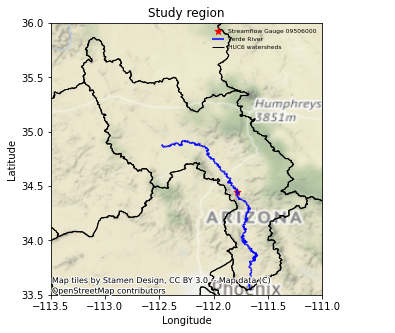

In [31]:
# Read USGS WBD file
file = os.path.join('..', 'data/WBD_15_HU2_GDB', 'WBD_15_HU2_GDB.gdb')
fiona.listlayers(file)
HUC6 = gpd.read_file(file, layer="WBDHU6")

# Read Major River file
file = os.path.join('..', 'data/Major Rivers', 'Major Rivers.shp')
rivers = gpd.read_file(file)
rivers_project   = rivers.to_crs(HUC6.crs)
rivers_verde_project = rivers_project[rivers_project['NAME'] == 'Verde River']

# Create streamflow gauge point
point_list = np.array([[-111.7891667, 34.44833333]])
point_geom = [Point(xy) for xy in point_list]
point_df = gpd.GeoDataFrame(point_geom, columns=['geometry'], crs=HUC6.crs)

# Plot study basin
fig, ax = plt.subplots(figsize=(5, 5))
point_df.loc[[0]].plot(ax=ax, color='red', marker='*', markersize=50, label='Streamflow Gauge 09506000')
rivers_verde_project.plot(ax=ax, color='blue', label='Verde River')
HUC6.boundary.plot(ax=ax, color=None, 
                   edgecolor='black', linewidth=1, label='HUC6 watersheds')
ctx.add_basemap(ax, crs=HUC6.crs, alpha=0.7)

ax.set(title='Study region', xlabel='Longitude', ylabel='Latitude', xlim=(-113.5, -111), ylim=(33.5, 36))
ax.legend(fontsize=6, frameon=False)
plt.show()
#fig.savefig('studyregion.jpg', dpi=400)

To Perform flow prediction for next week and two weeks later, we need to historical precipitation and flow changes as well as their relationship:
</br>
* Read NCEP precipitation rate (mm/s) netcdf file that covers the HUC1506 region and compute the basin-averaged weekly precipitation

In [32]:
prate_path = os.path.join('..', 'data', 'X70.164.250.222.314.12.56.9.nc')
prate = xr.open_dataset(prate_path)
# Compute the basin-averaged precipitation in mm/day
avg_prate = prate.mean(['lat', 'lon'])
avg_prate = avg_prate.to_dataframe()
wk_prate = avg_prate.resample('W').mean()
wk_prate['prate'] = wk_prate['prate']*3600.*24.

* Fetch daily streamflow from USGS website using nwis package and compute weekly flow

In [33]:
station_id = "09506000"
strfdata = nwis.get_record(sites=station_id, service='dv', start='2000-01-01', end='2021-11-08', parameterCd='00060')
strfdata.columns = ['flow', 'agency_cd', 'site_no']
wk_flow = strfdata.resample('W').mean()

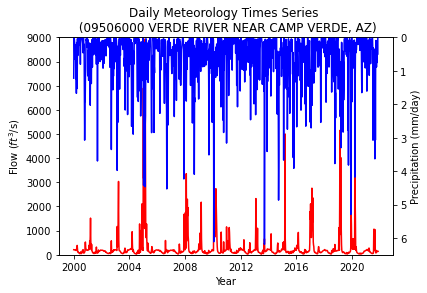

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(wk_flow.index, wk_flow.flow, color='red')

ax2 = ax.twinx()
ax2.plot(wk_prate.index, wk_prate['prate'], color='blue')
ax2.invert_yaxis()

ax.set(title="Daily Meteorology Times Series \n (09506000 VERDE RIVER NEAR \
CAMP VERDE, AZ)",  xlabel="Year", ylabel=r'Flow ($ft^3$/s)', ylim=(0, 9000))
ax2.set(ylabel='Precipitation (mm/day)', ylim=(6.5, 0))

plt.show()

* Generate 1- and 2-week flow forecast

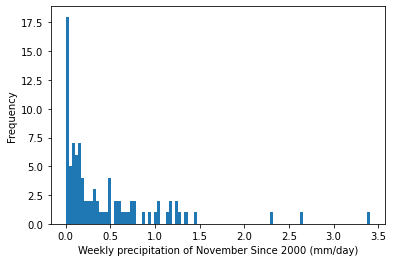

,prate
count,92.000000
mean,0.442275
std,0.588589
min,0.000000
25%,0.069336
50%,0.181322
75%,0.615109
max,3.410778


In [35]:
# Frequency distribution of November precipitation since 2000

fig, ax= plt.subplots()

ax.hist(wk_prate[wk_prate.index.month == 11], bins=100)
ax.set(xlabel='Weekly precipitation of November Since 2000 (mm/day)', ylabel='Frequency')
plt.show()

wk_prate[wk_prate.index.month == 11].describe()

In [36]:
# Reshape the precipitation input as lm needs

x = wk_prate['prate'].values.reshape(-1, 1)
y = wk_flow['flow'].values

# wk1_prate is assumed as 25 percentile of weekly November prate
wk1_prate = 0.069
print('----Here is flow during this weeks------')
lm_forecast(x, y, wk1_prate)

# wk2_prate is assumed as zero because it reaches the end of November and should have minimum prate
wk2_prate = 0.
print('----Here is flow during two weeks later------')
lm_forecast(x, y, wk2_prate)

----Here is flow during this weeks------
coefficient of determination: 0.09
intercept: 138.86
slope: [253.52]
 Weekly flow is  [156.4]
----Here is flow during two weeks later------
coefficient of determination: 0.09
intercept: 138.86
slope: [253.52]
 Weekly flow is  [138.9]


#### New analysis: Time series decomposition 
Because I did not find the intereseting thing in the gallery, I used time series decomposition from this link (https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/). The times series decomposition of monthly historical streamflow and precipitation does not show significant trends. However, the flow decomposition do show similar patterns with that of precipitation, indicating that precipitation likely dominates flow regimes!

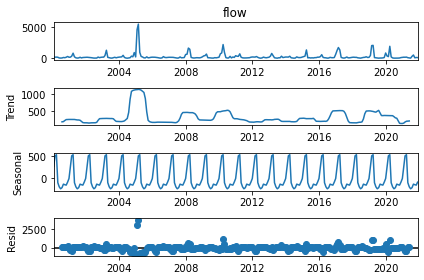

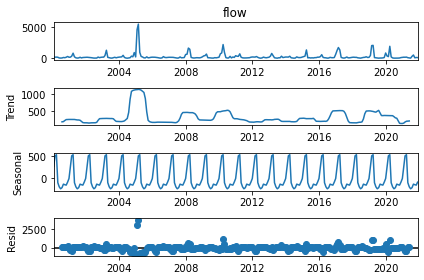

In [37]:
# Monthly streamflow (cfs) time series decomposition

m_flow = wk_flow['flow'].resample('m').mean()
flow_stl = seasonal_decompose(m_flow, model='additive', period=12)

flow_stl.plot()


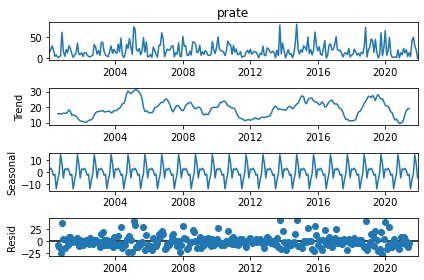

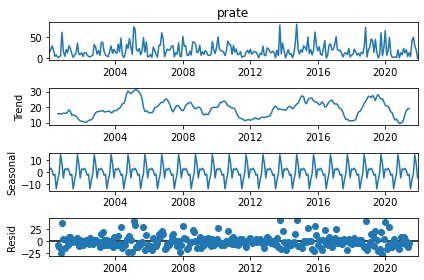

In [38]:
# Monthly precipitation time series decomposition (mm/month)

m_prate = wk_prate['prate'].resample('m').sum()*7.
prate_stl = seasonal_decompose(m_prate, model='additive', period=12)

prate_stl.plot()

#### Summary:
</br>
Overall, my flow forecast method is becoming more complicated and physically explanable. At the begining of this class, I simply guessed flow values primarily based on flows during last two weeks. With the help of linear regression models, I started to build autoregressive flow model with one- or two-week lags. However, the prediction is still lack of physical meanings. This time, I built a linear flow model cooresponding to precipitation changes using data since 2000. Here, year 2000 was chosen because of the apparent flow changes and climate change. Based on the frequency distribution of weekly precipitation during November, I picked the weekly precipitation for one- and two-week later.